#Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/home/franko/anaconda3/envs/critical/bin/python


# Install dependencies:

In [2]:
install_packages = True
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /home/franko/anaconda3/envs/critical

  added / updated specs:
    - tensorflow=2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _tflow_select-2.3.0        |              mkl           2 KB
    absl-py-0.11.0             |   py36h5fab9bb_0         168 KB  conda-forge
    aiohttp-3.7.3              |   py36h1d69622_0         612 KB  conda-forge
    astor-0.8.1                |     pyh9f0ad1d_0          25 KB  conda-forge
    astunparse-1.6.3           |             py_0          17 KB
    async-timeout-3.0.1        |          py_1000          11 KB  conda-forge
    blinker-1.4                |             py_1          13 KB  

# Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [5]:
data_path = './data/video_comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [5]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Creation of the directory ./output/ failed


# Load Data
Load you data as a pandas dataframe

In [6]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

In [7]:
data.head()

,id,replyCount,likeCount,publishedAt,authorName,text,authorChannelId,authorChannelUrl,isReply,isReplyTo,isReplyToName
0,UgzXkhhHxJSoZV0MfzZ4AaABAg,434.0,6309,2020-09-29 09:57:31,Kurzgesagt – In a Nutshell,"We created our first app ‘Universe in a Nutshell’, together with Tim Urban of Wait but Why! You can get it here:<br />Appstore: <a href=""http://kgs.link/universe-app-ios"">http://kgs.link/universe-app-ios</a><br />Google Playstore: <a href=""http://kgs.link/universe-app-android"">http://kgs.link/universe-app-android</a>",UCsXVk37bltHxD1rDPwtNM8Q,http://www.youtube.com/channel/UCsXVk37bltHxD1rDPwtNM8Q,0,NaN,NaN
1,UgzXkhhHxJSoZV0MfzZ4AaABAg.9EBLZuEXYdW9FrydWe06PW,NaN,0,2020-11-10 05:06:24,Gustavo Oliveira,"Kurzgesagt – In a Nutshell Missing Conventional Agriculture: in addition to poisoning the soil the water and our food, plowing the soil releases CO2 and moisture (H2O) from the soil to the atmosphere(Animal confinement also is bad).... Even if we stop emitting CO2 into the atmosphere with clean energy what was released from CO2 during all this time would still be there. The solution would be to capture CO2 for the soil, this technology has been around for a long time, the system of a forest ... ragriculture regeneration and forest gardening are revolutionary proposals. Source: Watch the Netflix documentary - KISS THE GROUND",UCPNSChmyPh0DY-gCGzOwaSA,http://www.youtube.com/channel/UCPNSChmyPh0DY-gCGzOwaSA,1,UgzXkhhHxJSoZV0MfzZ4AaABAg,Kurzgesagt – In a Nutshell
2,UgzXkhhHxJSoZV0MfzZ4AaABAg.9EBLZuEXYdW9FSDdj93tfS,NaN,1,2020-10-30 19:46:45,faik Idrizi,Kurzgesagt — In a Nutshell Can you to a video about why is difficult to replace patrol cars and diesel cars?,UCP0vU0onuc0AJ381ILxSEUw,http://www.youtube.com/channel/UCP0vU0onuc0AJ381ILxSEUw,1,UgzXkhhHxJSoZV0MfzZ4AaABAg,Kurzgesagt – In a Nutshell
3,UgzXkhhHxJSoZV0MfzZ4AaABAg.9EBLZuEXYdW9FPVz43WoHp,NaN,0,2020-10-29 18:29:14,Kin H,"Read between the lines, dummy's. That means you reading this comment. Read between the lines.",UCVSFqbn8wA5kDa_Ftfxx7Vg,http://www.youtube.com/channel/UCVSFqbn8wA5kDa_Ftfxx7Vg,1,UgzXkhhHxJSoZV0MfzZ4AaABAg,Kurzgesagt – In a Nutshell
4,UgzXkhhHxJSoZV0MfzZ4AaABAg.9EBLZuEXYdW9EKAFKMWsDL,NaN,1,2020-10-02 20:11:45,Dee Jay,Brilliant video! Request you to make continent or country specific videos assessing and highlighting what they are doing and what they need to do to meet the need of the hour. Thank you!,UCPQiz2IJQIEqIPQXYfugvhQ,http://www.youtube.com/channel/UCPQiz2IJQIEqIPQXYfugvhQ,1,UgzXkhhHxJSoZV0MfzZ4AaABAg,Kurzgesagt – In a Nutshell


In [8]:
data = data[0:10000] #need to remove entires due to my memory

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [9]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [11]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
   # keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

100%|██████████| 10000/10000 [00:01<00:00, 5168.11it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [8]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

NameError: name 'data' is not defined

In [9]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   publishedAt  10000 non-null  object
 1   authorName   10000 non-null  object
 2   text         10000 non-null  object
 3   isReply      10000 non-null  int64 
 4   cleaned      10000 non-null  object
dtypes: int64(1), object(4)
memory usage: 468.8+ KB


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [14]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [6]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//50):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

NameError: name 'data' is not defined

In [7]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.0000002   0.12140855  0.18548042 ...  0.09063593 -0.07056878
   0.02364509]
 [ 0.12140855  0.99999964  0.10248716 ...  0.19842285  0.02644138
  -0.05193333]
 [ 0.18548042  0.10248716  1.0000004  ...  0.16813257 -0.07957371
   0.02490871]
 ...
 [ 0.09063593  0.19842285  0.16813257 ...  1.0000002   0.03728629
   0.12623568]
 [-0.07056878  0.02644138 -0.07957371 ...  0.03728629  0.9999999
   0.00243481]
 [ 0.02364509 -0.05193333  0.02490871 ...  0.12623568  0.00243481
   1.0000005 ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

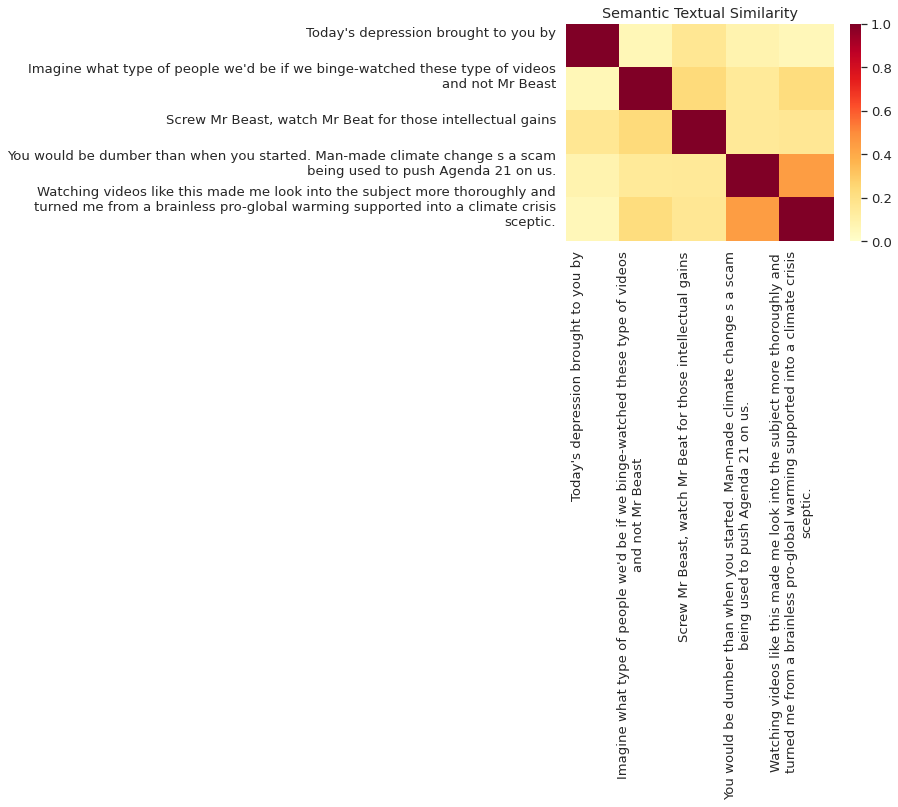

In [25]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 5000

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [22]:
comment_index = 17
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

Now this channel also has also become a shill for the Gates Foundation.




Print similar comments.

In [23]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: Now this channel also has also become a shill for the Gates Foundation.


Top similar comment 2: This channel is a mouth piece for Bill Gates' satanic ideology.


Top similar comment 3: Now this channel work with bill "big hitman in history" gates?? goodbye, giuda
"escariota" sicario!!!


Top similar comment 4: Man this channel is a bunch of unresearched bs


Top similar comment 5: Oh god now trump supporters are gonna assume this channel is supported by a
pedophile cabal


Top similar comment 6: Wow you found out what this channel is for! good for you!


Top similar comment 7: Sooo Bill Gates sponsors kurzgesagt now.... great.


Top similar comment 8: lol i thought this channel was all about science


Top similar comment 9: I fucking knew gates was all over this video


Top similar comment 10: if this channel becomes a president or any other high rank in politics the
world would probably be a better place


Top similar comment 11: Go vegan. Yes I've seen your vi